## Project 4
by Jiangyong Huang on Dec 3, 2022

**Learning deep generative model by alternative back-propagation**

In [8]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torchvision import transforms as T
from torchvision.utils import make_grid
%matplotlib inline
torch.manual_seed(1203)
torch.cuda.manual_seed(1203)

Configs

In [9]:
class Config(object):
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.langevin_steps = 20
        self.langevin_step_size = 0.1
        self.sigma = 1
        self.epochs = 1000
        self.lr = 1e-3
        self.interpolation_d = 5
        self.warm_start = None

args = Config()

Dataset

In [10]:
def load_data(data_dir='images'):
    imgs = []
    transform = T.Compose([T.Resize([128, 128]), T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    for fname in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, fname)).convert('RGB')
        img = transform(img)
        imgs.append(img)
    
    imgs = torch.stack(imgs)
    return imgs

Model

In [18]:
def set_cuda(deterministic=True):
    if torch.cuda.is_available():
        if deterministic:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        else:
            torch.backends.cudnn.deterministic = False
            torch.backends.cudnn.benchmark = True


class GenNet(nn.Module):
    def __init__(self):
        """
        Decode a 2-dim latent variable z to form an output image at 128x128.
        The latent z is first used for a combination of two base feature map at 4x4, which further goes through transposed conv to 128x128.
        (2) -> (512, 4, 4) -> (512, 8, 8) -> (256, 16, 16) -> (128, 32, 32) -> (64, 64, 64) -> (3, 128, 128)
        """
        super().__init__()
        self.latent_base = nn.Parameter(torch.zeros(2, 512*4*4))
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.block5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.to(self.latent_base.device)
        x = z.view(-1, 2) @ self.latent_base
        # [8192]
        x = x.view(-1, 512, 4, 4)
        # [512, 4, 4]
        x = self.block1(x)
        # [512, 8, 8]
        x = self.block2(x)
        # [256, 16, 16]
        x = self.block3(x)
        # [128, 32, 32]
        x = self.block4(x)
        # [64, 64, 64]
        x = self.block5(x)
        # [3, 128, 128]
        return x


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.xavier_normal_(m.weight)
    elif 'BatchNorm' in classname:
        m.weight.data.normal_(1, 0.02)
        m.bias.data.fill_(0)


def compute_logit(I, z, g, sigma):
    # return the log likelihood on joint distribution, log p(I,z|theta)
    I = I.to(g.device)
    return - ((I-g)**2).sum() / (2 * sigma**2) - (z**2).sum() / 2


class Model(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.langevin_steps = args.langevin_steps
        self.langevin_step_size = args.langevin_step_size
        self.sigma = args.sigma
        self.lr = args.lr

        self.Generator = GenNet()
        self.Generator.apply(weights_init_xavier)
        self.Generator.to(args.device)

    def sample_langevin(self, z, I, warm_start=True):
        if not warm_start:
            z = torch.randn(2)
        
        for i in range(self.langevin_steps):
            z = Variable(z.data, requires_grad=True)
            self.Generator.zero_grad()
            g = self.Generator(z)
            logit = compute_logit(I, z, g, self.sigma)
            logit.backward()

            norm = torch.linalg.norm(z.grad)
            if norm > 1:
                grad = z.grad / norm
            else:
                grad = z.grad
            noise = torch.randn_like(z, device=z.device)
            z.data += self.langevin_step_size**2 * grad / 2 + self.langevin_step_size * noise
        
        return z.detach()

    def update(self, latents, imgs, warm_start=True):
        """
        latents: [N, 2]
        imgs: [N, 3, 128, 128]
        """
        named_grads = {}
        z_new = []
        loss = []
        print('Collecting gradients')
        for z, I in zip(latents, imgs):
            z = self.sample_langevin(z, I, warm_start)

            self.Generator.zero_grad()
            g = self.Generator(z)
            logit = compute_logit(I, z, g, self.sigma)
            logit.backward()

            # collect gradients
            for n, p in self.Generator.named_parameters():
                if n not in named_grads.keys():
                    named_grads.update({n: []})
                named_grads[n].append(p.grad.data)
            
            z_new.append(z.view(-1, 2))
            # record loss (negative log likelihood)
            loss.append(-logit.detach().item())
        
        # update parameters
        print('Updating parameters')
        for n, p in self.Generator.named_parameters():
            grad = torch.stack(named_grads[n], dim=0).mean(0)
            norm = torch.linalg.norm(grad)
            if norm > 1:
                grad /= norm
            p.data += self.lr * grad

        return torch.cat(z_new, dim=0).detach(), np.mean(loss)

Visualization tools

In [12]:
@torch.no_grad()
def sample_img(model, z):
    sample = model.Generator(z)
    sample = sample.squeeze().detach().cpu().numpy()
    # [-1, 1] to [0, 1]
    sample = (sample + 1) / 2
    # [C, H, W] to [H, W, C]
    sample = sample.transpose(1, 2, 0)
    return sample


def visualize_img_tensor(img_tensor, title_str):
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]
    img_array = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    if img_array.mean() > 1:
        img_array = (img_array / 255).clip(0, 1)
    else:
        img_array = img_array.clip(0, 1)
    plt.figure()
    plt.imshow(img_array)
    plt.title(title_str)
    plt.axis('off')


@torch.no_grad()
def show_interpolation(model, d):
    # make 10x10 grids from interpolation within [-d, d] in latent space
    inter_range = torch.linspace(-d, d, 10)
    xs, ys = torch.meshgrid([inter_range, inter_range], indexing='xy')
    latents = torch.stack([xs, ys], dim=-1)
    latents = latents.reshape(-1, 2)   # [100, 2]
    samples = model.Generator(latents)
    samples = (samples + 1) / 2
    vis_grid = make_grid(samples, nrow=10)
    visualize_img_tensor(vis_grid, 'Interpolation in latent space')


def visualize_loss(losses):
    plt.figure()
    plt.plot(losses)
    plt.title('Loss over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

Experiment

In [13]:
def run(args):
    imgs = load_data()
    print(f'Loaded {len(imgs)} images')
    latents = torch.randn(len(imgs), 2)
    model = Model(args)
    losses = []
    for i in range(args.epochs):
        print(f'Epoch {i} update:')
        latents, loss = model.update(latents, imgs, args.warm_start)
        print(f'Epoch {i} loss: {loss:.4f}')
        losses.append(loss)
    
    visualize_loss(losses)
    
    plt.figure()
    plt.title('Random sample')
    plt.imshow(sample_img(model, torch.randn(2)))
    plt.axis('off')

    show_interpolation(model, args.interpolation_d)

Warm start

Loaded 11 images
Epoch 0 update:
Updating parameters
Epoch 0 loss: 14694.1272
Epoch 1 update:
Updating parameters
Epoch 1 loss: 14285.5442
Epoch 2 update:
Updating parameters
Epoch 2 loss: 13891.8097
Epoch 3 update:
Updating parameters
Epoch 3 loss: 13885.8010
Epoch 4 update:
Updating parameters
Epoch 4 loss: 13649.8286
Epoch 5 update:
Updating parameters
Epoch 5 loss: 13415.3176
Epoch 6 update:
Updating parameters
Epoch 6 loss: 13307.5075
Epoch 7 update:
Updating parameters
Epoch 7 loss: 13005.5139
Epoch 8 update:
Updating parameters
Epoch 8 loss: 12830.6221
Epoch 9 update:
Updating parameters
Epoch 9 loss: 12653.6732
Epoch 10 update:
Updating parameters
Epoch 10 loss: 12380.0906
Epoch 11 update:
Updating parameters
Epoch 11 loss: 12219.1461
Epoch 12 update:
Updating parameters
Epoch 12 loss: 12093.6548
Epoch 13 update:
Updating parameters
Epoch 13 loss: 12243.1768
Epoch 14 update:
Updating parameters
Epoch 14 loss: 12097.6585
Epoch 15 update:
Updating parameters
Epoch 15 loss: 12174.

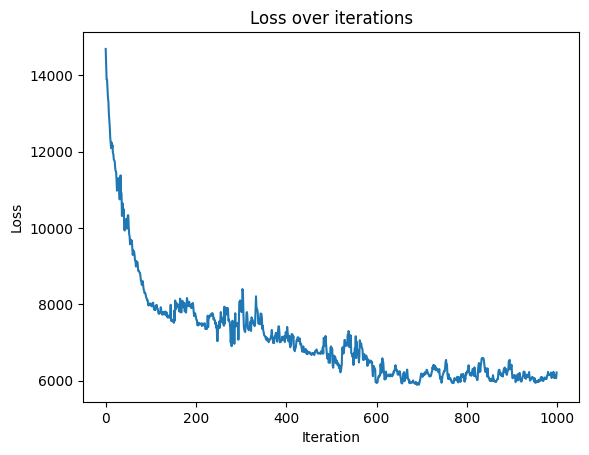

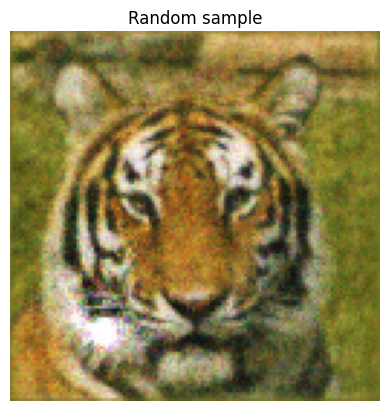

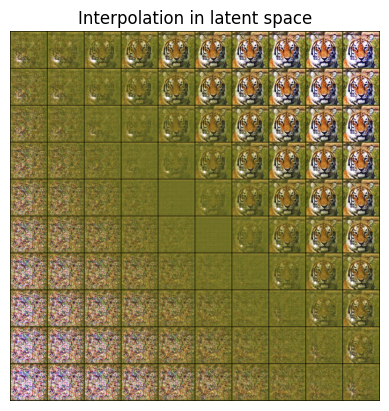

In [14]:
setattr(args, 'warm_start', True)
run(args)

Cold start

Loaded 11 images
Epoch 0 update:
Updating parameters
Epoch 0 loss: 14719.0265
Epoch 1 update:
Updating parameters
Epoch 1 loss: 14491.4553
Epoch 2 update:
Updating parameters
Epoch 2 loss: 13907.6601
Epoch 3 update:
Updating parameters
Epoch 3 loss: 13216.5684
Epoch 4 update:
Updating parameters
Epoch 4 loss: 12552.6382
Epoch 5 update:
Updating parameters
Epoch 5 loss: 12518.5598
Epoch 6 update:
Updating parameters
Epoch 6 loss: 11908.4850
Epoch 7 update:
Updating parameters
Epoch 7 loss: 11485.1218
Epoch 8 update:
Updating parameters
Epoch 8 loss: 12044.1321
Epoch 9 update:
Updating parameters
Epoch 9 loss: 11287.9044
Epoch 10 update:
Updating parameters
Epoch 10 loss: 11433.3254
Epoch 11 update:
Updating parameters
Epoch 11 loss: 11371.0875
Epoch 12 update:
Updating parameters
Epoch 12 loss: 11219.0518
Epoch 13 update:
Updating parameters
Epoch 13 loss: 10304.8632
Epoch 14 update:
Updating parameters
Epoch 14 loss: 11345.5815
Epoch 15 update:
Updating parameters
Epoch 15 loss: 11016.

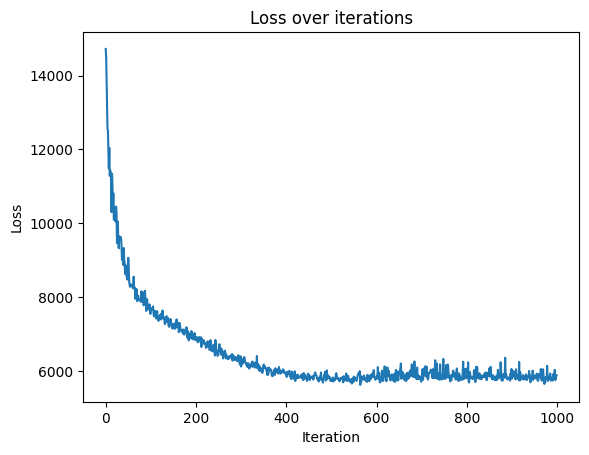

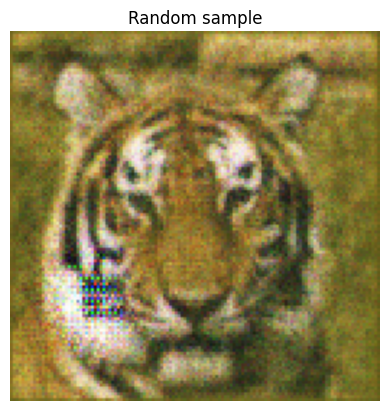

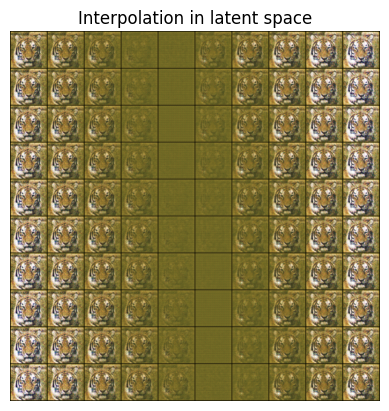

In [15]:
setattr(args, 'warm_start', False)
run(args)